Credits: Forked from [deep-learning-keras-tensorflow](https://github.com/leriomaggio/deep-learning-keras-tensorflow) by Valerio Maggio

In [2]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,pandas,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Gopala KR 
last updated: 2018-01-31 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.13.1
pandas 0.20.3
matplotlib 2.0.2
nltk 3.2.5
sklearn 0.19.0
tensorflow 1.3.0
theano 1.0.1
mxnet 1.0.0
chainer 3.3.0
seaborn 0.8.1


# Introduction to Deep Learning

Deep learning allows computational models that are composed of multiple processing **layers** to learn representations of data with multiple levels of abstraction.

These methods have dramatically improved the state-of-the-art in speech recognition, visual object recognition, object detection and many other domains such as drug discovery and genomics. 

**Deep learning** is one of the leading tools in data analysis these days and one of the most common frameworks for deep learning is **Keras**. 

The Tutorial will provide an introduction to deep learning using `keras` with practical code examples.

# Artificial Neural Networks (ANN)

In machine learning and cognitive science, an artificial neural network (ANN) is a network inspired by biological neural networks which are used to estimate or approximate functions that can depend on a large number of inputs that are generally unknown

An ANN is built from nodes (neurons) stacked in layers between the feature vector and the target vector. 

A node in a neural network is built from Weights and Activation function

An early version of ANN built from one node was called the **Perceptron**

<img src ="imgs/Perceptron.png" width="85%">

The Perceptron is an algorithm for supervised learning of binary classifiers. functions that can decide whether an input (represented by a vector of numbers) belongs to one class or another.

Much like logistic regression, the weights in a neural net are being multiplied by the input vertor summed up and feeded into the activation function's input.

A Perceptron Network can be designed to have *multiple layers*, leading to the **Multi-Layer Perceptron** (aka `MLP`)

<img src ="imgs/MLP.png" width="85%">

The weights of each neuron are learned by **gradient descent**, where each neuron's error is derived with respect to it's weight.

Optimization is done for each layer with respect to the previous layer in a technique known as **BackPropagation**.

<img src ="imgs/backprop.png" width="80%">

# Building Neural Nets from scratch 


### Idea:

We will build the neural networks from first principles. 
We will create a very simple model and understand how it works. We will also be implementing backpropagation algorithm. 

**Please note that this code is not optimized and not to be used in production**. 

This is for instructive purpose - for us to understand how ANN works. 

Libraries like `theano` have highly optimized code.

(*The following code is inspired from [these](https://github.com/dennybritz/nn-from-scratch) terrific notebooks*)

In [3]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [4]:
# Display plots inline 
%matplotlib inline
# Define plot's default figure size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [5]:
import random
random.seed(123)

In [6]:
#read the datasets
train = pd.read_csv("data/intro_to_ann.csv")

In [7]:
X, y = np.array(train.ix[:,0:2]), np.array(train.ix[:,2])

/srv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/srv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


In [8]:
X.shape

(500, 2)

In [9]:
y.shape

(500,)

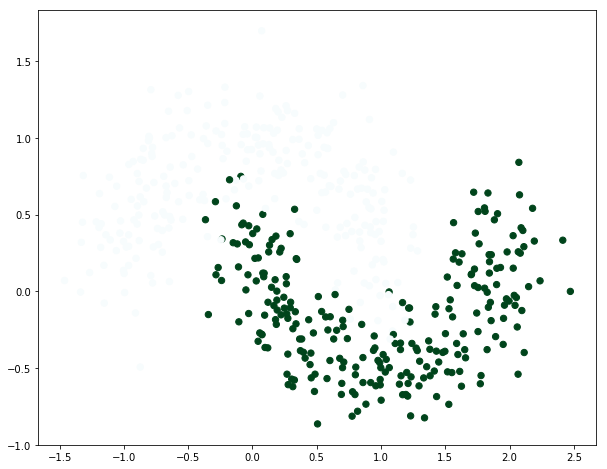

In [10]:
#Let's plot the dataset and see how it is
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.BuGn)

## Start Building our ANN building blocks

Note: This process will eventually result in our own Neural Networks class

### A look at the details

<img src="imgs/mlp_details.png" width="85%" />

### Function to generate a random number, given two numbers

**Where will it be used?**: When we initialize the neural networks, the weights have to be randomly assigned.

In [11]:
# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

In [12]:
# Make a matrix 
def makeMatrix(I, J, fill=0.0):
    return np.zeros([I,J])

### Define our activation function. Let's use sigmoid function

In [13]:
# our sigmoid function
def sigmoid(x):
    #return math.tanh(x)
    return 1/(1+np.exp(-x))

### Derivative of our activation function. 

Note: We need this when we run the backpropagation algorithm


In [14]:
# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return y - y**2

### Our neural networks class

When we first create a neural networks architecture, we need to know the number of inputs, number of hidden layers and number of outputs.

The weights have to be randomly initialized.

```python
class ANN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        self.wi = rand(-0.2, 0.2, size=self.wi.shape)
        self.wo = rand(-2.0, 2.0, size=self.wo.shape)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
```

### Activation Function

```python
def activate(self, inputs):
        
    if len(inputs) != self.ni-1:
        print(inputs)
        raise ValueError('wrong number of inputs')

    # input activations
    for i in range(self.ni-1):
        self.ai[i] = inputs[i]

    # hidden activations
    for j in range(self.nh):
        sum_h = 0.0
        for i in range(self.ni):
            sum_h += self.ai[i] * self.wi[i][j]
        self.ah[j] = sigmoid(sum_h)

    # output activations
    for k in range(self.no):
        sum_o = 0.0
        for j in range(self.nh):
            sum_o += self.ah[j] * self.wo[j][k]
        self.ao[k] = sigmoid(sum_o)

    return self.ao[:]
```

### BackPropagation

```python
def backPropagate(self, targets, N, M):
        
    if len(targets) != self.no:
        print(targets)
        raise ValueError('wrong number of target values')

    # calculate error terms for output
    output_deltas = np.zeros(self.no)
    for k in range(self.no):
        error = targets[k]-self.ao[k]
        output_deltas[k] = dsigmoid(self.ao[k]) * error

    # calculate error terms for hidden
    hidden_deltas = np.zeros(self.nh)
    for j in range(self.nh):
        error = 0.0
        for k in range(self.no):
            error += output_deltas[k]*self.wo[j][k]
        hidden_deltas[j] = dsigmoid(self.ah[j]) * error

    # update output weights
    for j in range(self.nh):
        for k in range(self.no):
            change = output_deltas[k] * self.ah[j]
            self.wo[j][k] += N*change + 
                             M*self.co[j][k]
            self.co[j][k] = change

    # update input weights
    for i in range(self.ni):
        for j in range(self.nh):
            change = hidden_deltas[j]*self.ai[i]
            self.wi[i][j] += N*change + 
                             M*self.ci[i][j]
            self.ci[i][j] = change

    # calculate error
    error = 0.0
    for k in range(len(targets)):
        error += 0.5*(targets[k]-self.ao[k])**2
    return error
```

In [15]:
# Putting all together

class ANN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
        

    def backPropagate(self, targets, N, M):
        
        if len(targets) != self.no:
            print(targets)
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = np.zeros(self.no)
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = np.zeros(self.nh)
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] += N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] += N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        self.predict = np.empty([len(patterns), self.no])
        for i, p in enumerate(patterns):
            self.predict[i] = self.activate(p)
            #self.predict[i] = self.activate(p[0])
            
    def activate(self, inputs):
        
        if len(inputs) != self.ni-1:
            print(inputs)
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh):
            sum_h = 0.0
            for i in range(self.ni):
                sum_h += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum_h)

        # output activations
        for k in range(self.no):
            sum_o = 0.0
            for j in range(self.nh):
                sum_o += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum_o)

        return self.ao[:]
    

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        patterns = list(patterns)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.activate(inputs)
                error += self.backPropagate([targets], N, M)
            if i % 5 == 0:
                print('error in interation %d : %-.5f' % (i,error))
            print('Final training error: %-.5f' % error)

### Running the model on our dataset

In [16]:
# create a network with two inputs, one hidden, and one output nodes
ann = ANN(2, 1, 1)

%timeit -n 1 -r 1 ann.train(zip(X,y), iterations=2)

error in interation 0 : 53.62995
Final training error: 53.62995
Final training error: 47.35136
53.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Predicting on training dataset and measuring in-sample accuracy

In [17]:
%timeit -n 1 -r 1 ann.test(X)

6.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
prediction = pd.DataFrame(data=np.array([y, np.ravel(ann.predict)]).T, 
                          columns=["actual", "prediction"])
prediction.head()

,actual,prediction
0,1.0,0.491100
1,1.0,0.495469
2,0.0,0.097362
3,0.0,0.400006
4,1.0,0.489664


In [19]:
np.min(prediction.prediction)

0.076553078113180129

### Let's visualize and observe the results

In [20]:
# Helper function to plot a decision boundary.
# This generates the contour plot to show the decision boundary visually
def plot_decision_boundary(nn_model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    nn_model.test(np.c_[xx.ravel(), yy.ravel()])
    Z = nn_model.predict
    Z[Z>=0.5] = 1
    Z[Z<0.5] = 0
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=40,  c=y, cmap=plt.cm.BuGn)

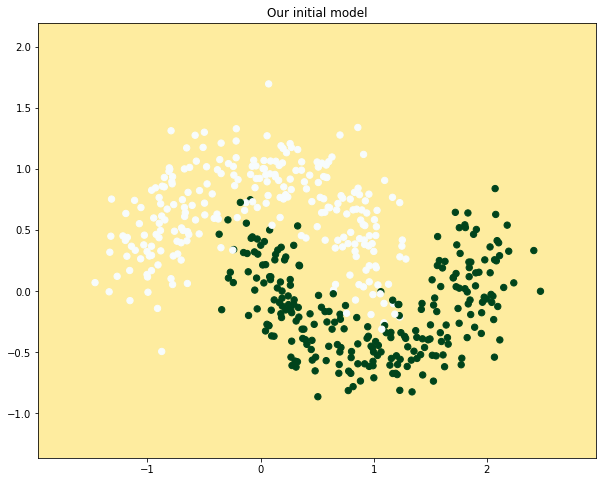

In [21]:
plot_decision_boundary(ann)
plt.title("Our initial model")

**Exercise**: 

Create Neural networks with 10 hidden nodes on the above code. 

What's the impact on accuracy?

In [22]:
# Put your code here 
#(or load the solution if you wanna cheat :-)

error in interation 0 : 34.91394
Final training error: 34.91394
Final training error: 25.36183
198 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


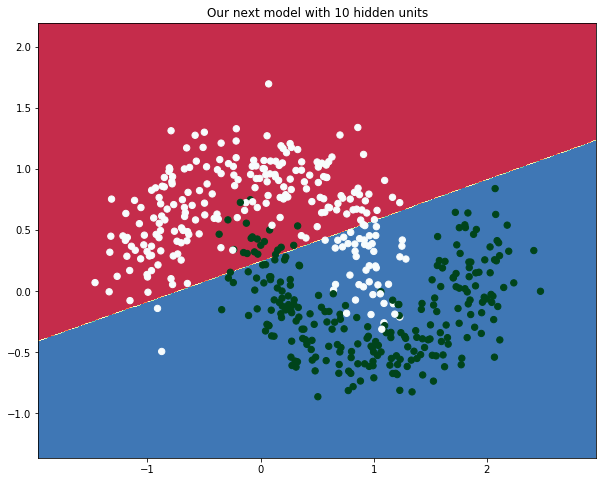

In [23]:
# %load solutions/sol_111.py
ann = ANN(2, 10, 1)
%timeit -n 1 -r 1 ann.train(zip(X,y), iterations=2)
plot_decision_boundary(ann)
plt.title("Our next model with 10 hidden units")


**Exercise:**

Train the neural networks by increasing the epochs. 

What's the impact on accuracy?

In [24]:
#Put your code here

error in interation 0 : 31.63185
Final training error: 31.63185
Final training error: 25.12319
Final training error: 24.92547
Final training error: 24.89692
Final training error: 24.88124
error in interation 5 : 24.86083
Final training error: 24.86083
Final training error: 24.83512
Final training error: 24.80603
Final training error: 24.77544
Final training error: 24.74477
error in interation 10 : 24.71498
Final training error: 24.71498
Final training error: 24.68669
Final training error: 24.66021
Final training error: 24.63569
Final training error: 24.61313
error in interation 15 : 24.59246
Final training error: 24.59246
Final training error: 24.57359
Final training error: 24.55639
Final training error: 24.54072
Final training error: 24.52646
error in interation 20 : 24.51350
Final training error: 24.51350
Final training error: 24.50171
Final training error: 24.49100
Final training error: 24.48127
Final training error: 24.47242
error in interation 25 : 24.46436
Final training error: 2

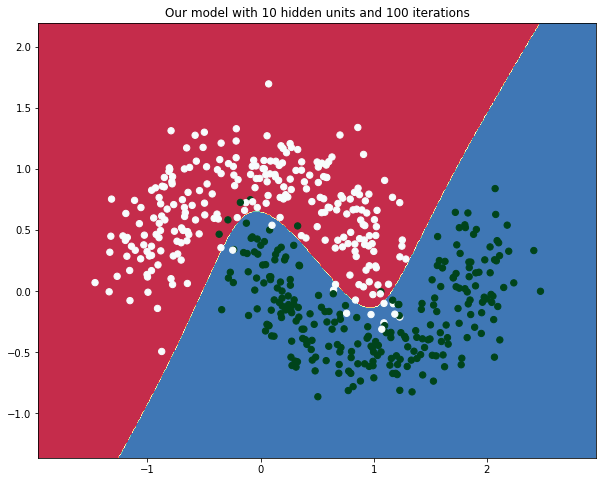

In [25]:
# %load solutions/sol_112.py
ann = ANN(2, 10, 1)
%timeit -n 1 -r 1 ann.train(zip(X,y), iterations=100)
plot_decision_boundary(ann)
plt.title("Our model with 10 hidden units and 100 iterations")


# Addendum

There is an additional notebook in the repo, i.e. [A simple implementation of ANN for MNIST](1.4 (Extra) A Simple Implementation of ANN for MNIST.ipynb) for a *naive* implementation of **SGD** and **MLP** applied on **MNIST** dataset.

This accompanies the online text http://neuralnetworksanddeeplearning.com/ . The book is highly recommended. 

In [ ]:
test complte; Gopal